# Summary

We're given a prompt from Facebook: 
> The goal of this competition is to predict which place a person would like to check in to. 
For the purposes of this competition, Facebook created an artificial world consisting of more than 100,000 places located in a 10 km by 10 km square. 
For a given set of coordinates, your task is to return a ranked list of the most likely places. 
Data was fabricated to resemble location signals coming from mobile devices, giving you a flavor of what it takes to work with real data complicated by inaccurate and noisy values. Inconsistent and erroneous location data can disrupt experience for services like Facebook Check In.

Rather than ask, “How do I model this artificial world?” let’s ask a different question, “How were these data generated?”
Treating this as an analysis problem, rather than a modeling problem,
could lead to deeper insights than tuning model hyperparameters.
Plus, it's a fun challenge. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats    
import scipy.special as sps
%matplotlib inline

In [4]:
# Read in the data using the first column as the index
df = pd.read_csv('train.csv', index_col=0)

In [5]:
df.head()

,x,y,accuracy,time,place_id
row_id,,,,,
0,0.7941,9.0809,54,470702,8523065625
1,5.9567,4.7968,13,186555,1757726713
2,8.3078,7.0407,74,322648,1137537235
3,7.3665,2.5165,65,704587,6567393236
4,4.0961,1.1307,31,472130,7440663949


In [6]:
df.describe()

,x,y,accuracy,time,place_id
count,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07,2.911802e+07
mean,4.999770e+00,5.001814e+00,8.284912e+01,4.170104e+05,5.493787e+09
std,2.857601e+00,2.887505e+00,1.147518e+02,2.311761e+05,2.611088e+09
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000016e+09
25%,2.534700e+00,2.496700e+00,2.700000e+01,2.030570e+05,3.222911e+09
50%,5.009100e+00,4.988300e+00,6.200000e+01,4.339220e+05,5.518573e+09
75%,7.461400e+00,7.510300e+00,7.500000e+01,6.204910e+05,7.764307e+09
max,1.000000e+01,1.000000e+01,1.033000e+03,7.862390e+05,9.999932e+09


# Tour of the variables
Let's pause and see what we're dealing with. 

## row_id
The primary key for our data. Nothing to see here...

## x, y
We're told this is a 10 km x 10 km square and, indeed, x and y run between 0 and 10 so it’s probably fair to assume the units of x and y are kilometers. 
The precision of x and y is 0.0001 km which is 10 cm (that’s 4 in in Menlo Park).

## accuracy
This is interesting. `accuracy` varies between 1-1033 with an average of 82.8. 
It's given as an integer which is odd. 

## time
Again an integer. Based on previous analyses, we suspect its units of are minutes. 

## place_id
`place_id` ranges between $10^9$ and $10^{10}$. 
There are $9\times10^9$ possible unique values but only $2.9\times10^7$ were used, 0.3% of the availability. 
It's a odd choice given $9.99\times10^{32}/2^{32} = 2.3$ because it just overflows the SQL `INT` data type. 

In [7]:
nb_total = df.place_id.count()
nb_unique = df.place_id.drop_duplicates().count()

print('Number place_ids: {}'.format(nb_total))
print('Unique place_ids: {}'.format(nb_unique))
print("Average number of duplicates: %.1f" % (nb_total/nb_unique))

Number place_ids: 29118021
Unique place_ids: 108390
Average number of duplicates: 268.6


There are an average of 269 check ins per place. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd866a19b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efd849da518>]], dtype=object)

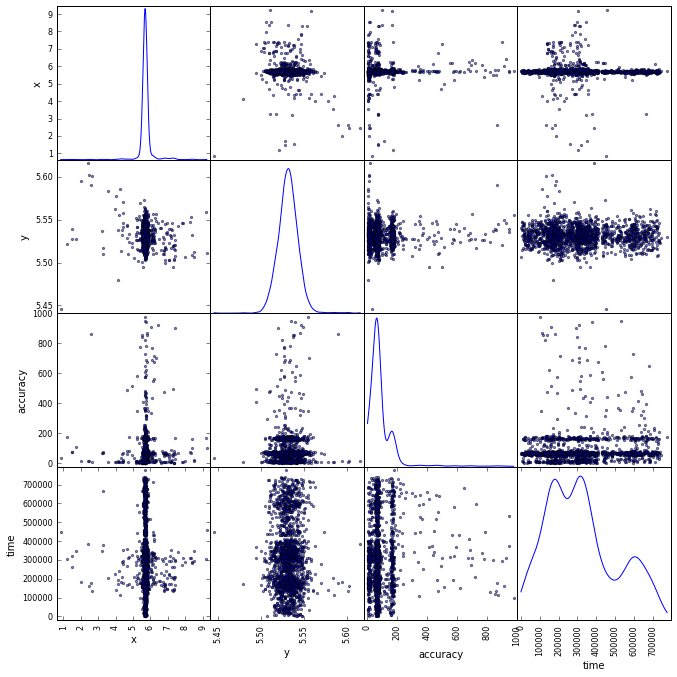

In [15]:
from pandas.tools.plotting import scatter_matrix
df_sample = df[df.place_id == 4823777529]
scatter_matrix(df_sample.drop('place_id', axis=1), diagonal='kde', figsize=(11,11))

`x` and `y` are look gaussian but `accuracy` and `time` are something more complicated. Again we see how all these variables are uncorrelated and the scatter in `x` is much greater than in `y`.

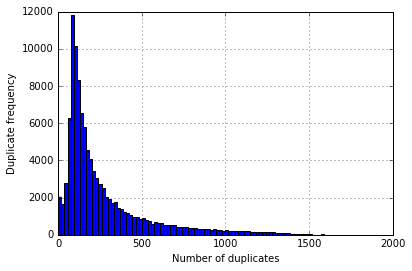

In [19]:
y = df.place_id.value_counts().hist(bins=100)
y.set(ylabel="Duplicate frequency", xlabel="Number of duplicates")

(0, 2000)

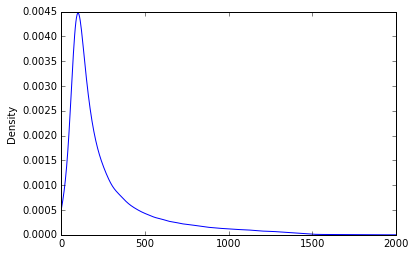

In [20]:
y = df.place_id.value_counts().plot.kde()
y.set_xlim(0, 2000)

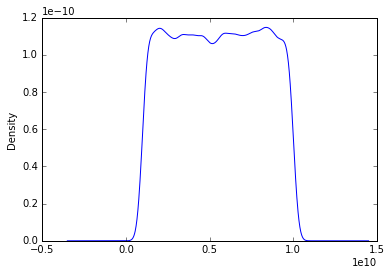

In [27]:
df.place_id.sample(1e5, replace=True).plot.kde()

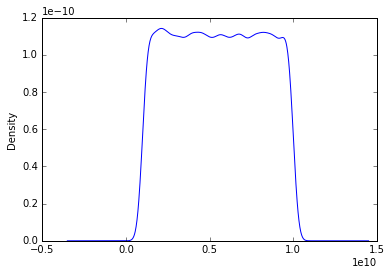

In [28]:
df.place_id.drop_duplicates().sample(1e5, replace=True).plot.kde()

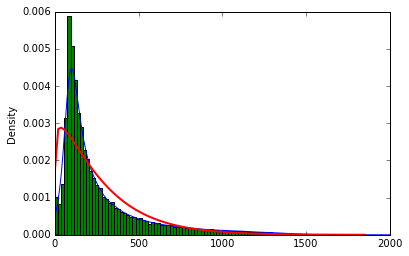

In [17]:
shape, scale = 1.34, 199.38 # mean and dispersion

s = df.place_id.value_counts().values

#Display the histogram of the samples, along with the probability density function:
ax = df.place_id.value_counts().plot.kde()
ax.set_xlim(0, 2000)

count, bins, ignored = plt.hist(s, 100, normed=True)
#y = bins**(shape-1)*(np.exp(-bins/scale) /
#                      (sps.gamma(shape)*scale**shape))
#y = stats.gamma.pdf(bins, a=.6, loc=.999, scale=2.0549)
#rv = stats.maxwell(loc=-249.6547, scale=336.860199)
rv = stats.frechet_r(1.1, loc=0.89, scale=280)
y = rv.pdf(bins)
ax.plot(bins, y, linewidth=2, color='r')

In [30]:
stats.gamma.fit(s, floc=0)

(1.3473190316157855, 0, 199.38945861010063)

In [32]:
s

array([1849, 1802, 1757, ...,    1,    1,    1])

In [33]:
s.mean()

268.64121228895652

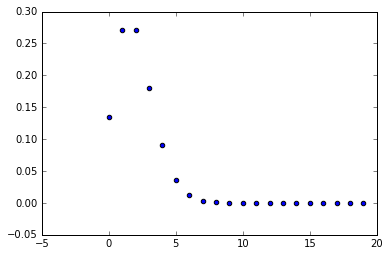

In [91]:
x = np.arange(20)
lam = 2
y = plt.scatter(x, (lam**x)*np.exp(-lam)/sps.factorial(x))
# ax = plt.gca()
# ax.set_ylim(0, .003)

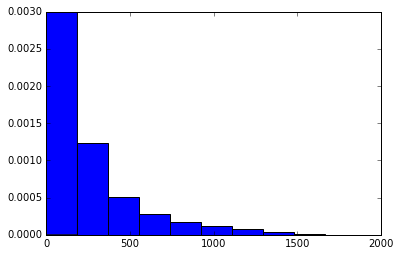

In [78]:
n, bins, patches = plt.hist(s, normed=1)

In [94]:
n.mean()**-1

1848.0

In [95]:
n.var()**-2

1597233050793.7043

In [63]:
y

In [66]:
bins

array([  1.00000000e+00,   1.85800000e+02,   3.70600000e+02,
         5.55400000e+02,   7.40200000e+02,   9.25000000e+02,
         1.10980000e+03,   1.29460000e+03,   1.47940000e+03,
         1.66420000e+03,   1.84900000e+03])

In [76]:
n

array([  2.98994452e-03,   1.23347068e-03,   5.04231753e-04,
         2.73533245e-04,   1.71838187e-04,   1.15923379e-04,
         7.76816442e-05,   3.70934844e-05,   6.39026379e-06,
         1.14825053e-06])

In [85]:
stats.poisson.rvs(10, .005)

9

In [92]:
s.var()

71793.644986665808

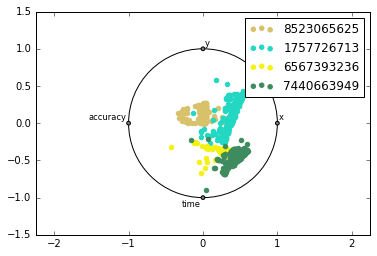

In [16]:
from pandas.tools.plotting import radviz
df2 = df[(df.place_id == 8523065625) | 
         (df.place_id == 6567393236) | 
         (df.place_id == 1757726713) | 
         (df.place_id == 7440663949)]

radviz(df2, 'place_id')